In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import pdb
from neurosim.models.ssr import StateSpaceRealization as SSR

In [3]:
# Is log det W_C submodular for additing columns of A?

In [4]:
from scipy.stats import ortho_group

In [5]:
# Generate a real valued non normal matrix
def real_nn(size, std):
    T = np.random.normal(size=(size, size))
    # Remove the lower half
    row_idxs, col_idxs = np.tril_indices(size)
    for i in range(row_idxs.size):
        T[row_idxs[i], col_idxs[i]] = 0
    # Ensure stability
    np.fill_diagonal(T, np.random.uniform(0, std, size=(size,)))

    # Random Schur bases
    U = ortho_group.rvs(dim=size)
    A = U.T @ T @ U
    return A

In [16]:
logdetB

-55.755065800012765

In [20]:
np.abs(np.linalg.eigvals(MA))

array([3.20412203, 3.1425564 , 3.1425564 , 2.61101487, 2.61101487,
       2.49515846, 2.49515846, 2.99456977, 2.99456977, 2.6785435 ,
       2.6785435 , 2.76214038, 2.76214038, 2.96850655, 2.6000406 ,
       2.6000406 , 1.82578796, 1.82578796, 1.50233071, 1.50233071,
       1.64652285, 1.64652285, 0.44073644, 0.44073644, 0.31129069])

In [6]:
# Over 100 reps, choose 100 random orderings of the indices and build the columns up unit by unit. Leave B 
# as the identity, solve the Lyapunov equation. Choose all the possible new indices to add on, and check 
# submodularity
#nn_strength = np.linspace(0, 1, 10)
nn_strength = np.array([0.1])
reps = 100

logdetAdiff = np.zeros((nn_strength.size, reps, 50)) 
logdetBdiff = np.zeros((nn_strength.size, reps, 50)) 

for i in range(nn_strength.size):
    M = real_nn(100, nn_strength[i])
    for j in range(reps):

        idx_order = np.random.permutation(100)

        # Set the set 'B' to be half of the idx_order
        B = idx_order[0:50]
        MB = M[B][:, B]
        
        WB = scipy.linalg.solve_discrete_lyapunov(MB, np.eye(MB.shape[0]))
        logdetB = np.linalg.slogdet(WB)[1]
                                                         
        # Set the set 'A' to be a quarter of the idx_order
        A = idx_order[0:25]
        MA = M[A][:, A]
        
        WA = scipy.linalg.solve_discrete_lyapunov(MA, np.eye(MA.shape[0]))
        logdetA = np.linalg.slogdet(WA)[1]
        
        # Set of possible indices to add
        C = idx_order[50::]
        
        for l, k in enumerate(C):
            
            corner_element = M[k, k]
            row = M[A][:, k]
            column = M[k, :][A]
            MAadd = np.vstack([MA, row])
            MAadd = np.hstack([MAadd, np.append(column, corner_element)[:, np.newaxis]])
            
            W = scipy.linalg.solve_discrete_lyapunov(MAadd, np.eye(MAadd.shape[0]))
            
            logdetAdiff[i, j, l] = np.linalg.slogdet(W)[1] - logdetA
            
            corner_element = M[k, k]
            row = M[B, k]
            column = M[k, B]
            MBadd = np.vstack([MB, row])
            MBadd = np.hstack([MBadd, np.append(column, corner_element)[:, np.newaxis]])
            
            W = scipy.linalg.solve_discrete_lyapunov(MBadd, np.eye(MBadd.shape[0]))

            logdetBdiff[i, j, l] = np.linalg.slogdet(W)[1] - logdetB

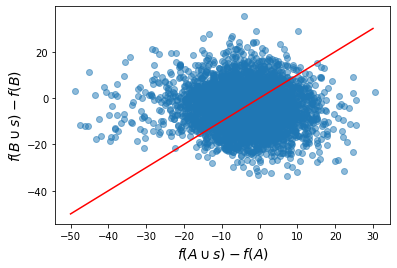

In [12]:
plt.scatter(logdetAdiff[0, ...].ravel(), logdetBdiff[0, ...].ravel(), alpha=0.5)
plt.plot(np.linspace(-50, 30), np.linspace(-50, 30), 'r')

plt.ylabel(r'$f(B \cup {s}) - f(B)$', fontsize=14)
plt.xlabel(r'$f(A \cup {s}) - f(A)$', fontsize=14)
plt.savefig('nosubmodularity.pdf', bbox_inches='tight', pad_inches=0)